# Imports

In [40]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize,regexp_tokenize
import seaborn as sns
import warnings
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings('ignore')
mpl.style.use("ggplot")
from textblob import TextBlob
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from nltk.corpus import stopwords
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from langdetect import detect_langs
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import contractions
from tqdm import tqdm
import plotly.express as px

<IPython.core.display.Javascript object>

# Exploring Dataset

In [41]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


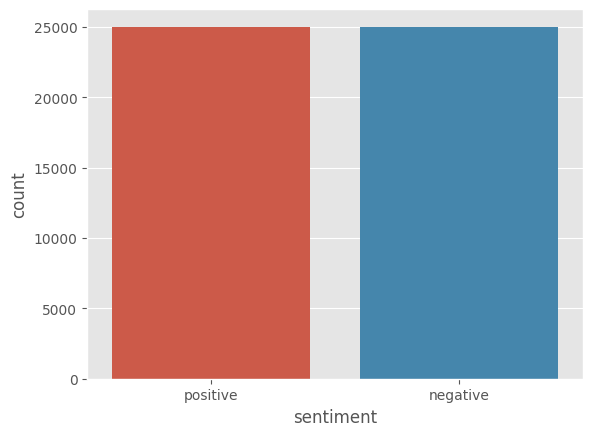

In [42]:
sns.countplot(df['sentiment'])
plt.show()

Classes are balanced

# Cleaning Sentiment

In [43]:
def cleaning_sentiment(df,col_name):
    porter = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    w = df[col_name].apply(lambda x :x.lower())
    w = w.apply(lambda x: re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])','',x))
    w = w.apply(lambda x: contractions.fix(x))
    w = w.apply(lambda x: ' '.join([porter.stem(i) for i in word_tokenize(x) if i not in stop_words]))
    return w

In [44]:
df['review'] = cleaning_sentiment(df,'review')

# Feature Extraction

In [45]:
def extracting_len_of_sentiment (df,col_name):
   w = df[col_name].apply(lambda x :x.lower())
   len_of_review = [len(word_tokenize(i)) for i in w] 
   return len_of_review

In [46]:
df['n_of_words'] = extracting_len_of_sentiment(df,'review')
df.head()

,review,sentiment,n_of_words
0,one review mention watch 1 oz episod hook righ...,positive,163
1,wonder littl product film techniqu unassum old...,positive,84
2,thought wonder way spend time hot summer weeke...,positive,85
3,basic famili littl boy jake think zombi closet...,negative,64
4,petter mattei love time money visual stun film...,positive,125


In [47]:
lb = LabelBinarizer()
df['sentiment'] = lb.fit_transform(df['sentiment'])
lb.classes_

array(['negative', 'positive'], dtype='<U8')

In [48]:
df['list_of_words'] = df['review'].apply(lambda x:str(x).split()) 

# Most common words in positive, and negative sentiment

In [49]:
pos_sent = df[df['sentiment']==1]
neg_sent = df[df['sentiment']==0]

In [50]:
common = Counter([item for i in pos_sent['list_of_words'] for item in i])
temp_pos = pd.DataFrame(common.most_common(20))
temp_pos.columns = ['Common_words','count']

In [51]:
fig = px.bar(temp_pos, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [52]:
common = Counter([item for i in neg_sent['list_of_words'] for item in i])
temp_neg = pd.DataFrame(common.most_common(20))
temp_neg.columns = ['Common_words','count']

In [53]:
fig = px.bar(temp_neg, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

# CountVectorizer

In [54]:
X = df['review']
y = df['sentiment']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# stratify = y to train  equally on both classes

# Count Vectorizer

In [56]:
vect = CountVectorizer()
X_train_count_vectorizer=vect.fit_transform(X_train)
X_test_count_vectorizer=vect.transform(X_test)
print(X_train_count_vectorizer.shape, X_test_count_vectorizer.shape)

(40000, 156171) (10000, 156171)


# tf-idf

In [57]:
tf =TfidfVectorizer()
X_train_tfidf_vectorizer=tf.fit_transform(X_train)
X_test_tfidf_vectorizer=tf.transform(X_test)
print(X_train_tfidf_vectorizer.shape, X_test_tfidf_vectorizer.shape)

(40000, 156171) (10000, 156171)


# Modeling
try not to use trees when you have many feature like this, you will see in testing set the result of trees

In [58]:
def testing_various_clf (X_train,X_test,y_train,y_test):
    ones = [i for i in y_train if i==1]
    print(f"model trained on: {len(ones)} of ones, while: {(len(y_train)-len(ones))} of zeros")
    models = [("logistic Regression",LogisticRegression()),("Decision Tree",DecisionTreeClassifier()), ("MultinomialNB",MultinomialNB())]
    for name,model in models:
        print(f"{'-'*88}\n{name}\n{'-'*88}")
        y_pred = model.fit(X_train,y_train).predict(X_test)
        print(f"Recall score: {round(recall_score(y_test,y_pred),3)}, precision score: {round(precision_score(y_test,y_pred),3)}, f1-score: {round(f1_score(y_test,y_pred),3)},accuracy score: {round(accuracy_score(y_test,y_pred),3)}\n")
        print(pd.DataFrame(confusion_matrix(y_test,y_pred)))    
        print(f"number of unique predicted classes: {np.unique(y_pred)}")

# Performance on Count vectorized data

In [59]:
testing_various_clf(X_train_count_vectorizer,X_test_count_vectorizer,y_train,y_test)

model trained on: 20000 of ones, while: 20000 of zeros
----------------------------------------------------------------------------------------
logistic Regression
----------------------------------------------------------------------------------------
Recall score: 0.889, precision score: 0.876, f1-score: 0.882,accuracy score: 0.882

      0     1
0  4370   630
1   555  4445
number of unique predicted classes: [0 1]
----------------------------------------------------------------------------------------
Decision Tree
----------------------------------------------------------------------------------------
Recall score: 0.734, precision score: 0.728, f1-score: 0.731,accuracy score: 0.73

      0     1
0  3626  1374
1  1331  3669
number of unique predicted classes: [0 1]
----------------------------------------------------------------------------------------
MultinomialNB
----------------------------------------------------------------------------------------
Recall score: 0.843, precisi

# Performance on tdidf vectorized data

In [60]:
testing_various_clf(X_train_tfidf_vectorizer,X_test_tfidf_vectorizer,y_train,y_test)

model trained on: 20000 of ones, while: 20000 of zeros
----------------------------------------------------------------------------------------
logistic Regression
----------------------------------------------------------------------------------------
Recall score: 0.904, precision score: 0.883, f1-score: 0.893,accuracy score: 0.892

      0     1
0  4400   600
1   478  4522
number of unique predicted classes: [0 1]
----------------------------------------------------------------------------------------
Decision Tree
----------------------------------------------------------------------------------------
Recall score: 0.724, precision score: 0.724, f1-score: 0.724,accuracy score: 0.724

      0     1
0  3619  1381
1  1380  3620
number of unique predicted classes: [0 1]
----------------------------------------------------------------------------------------
MultinomialNB
----------------------------------------------------------------------------------------
Recall score: 0.856, precis